In [246]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from ultralytics import YOLO


from byol_pytorch  import BYOL
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import OPTICS

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from torch.utils.tensorboard import SummaryWriter

import umap
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os

In [3]:
im = Image.open("data/train/YFT/img_00137.jpg")  #data/train/SHARK/img_00247.jpg

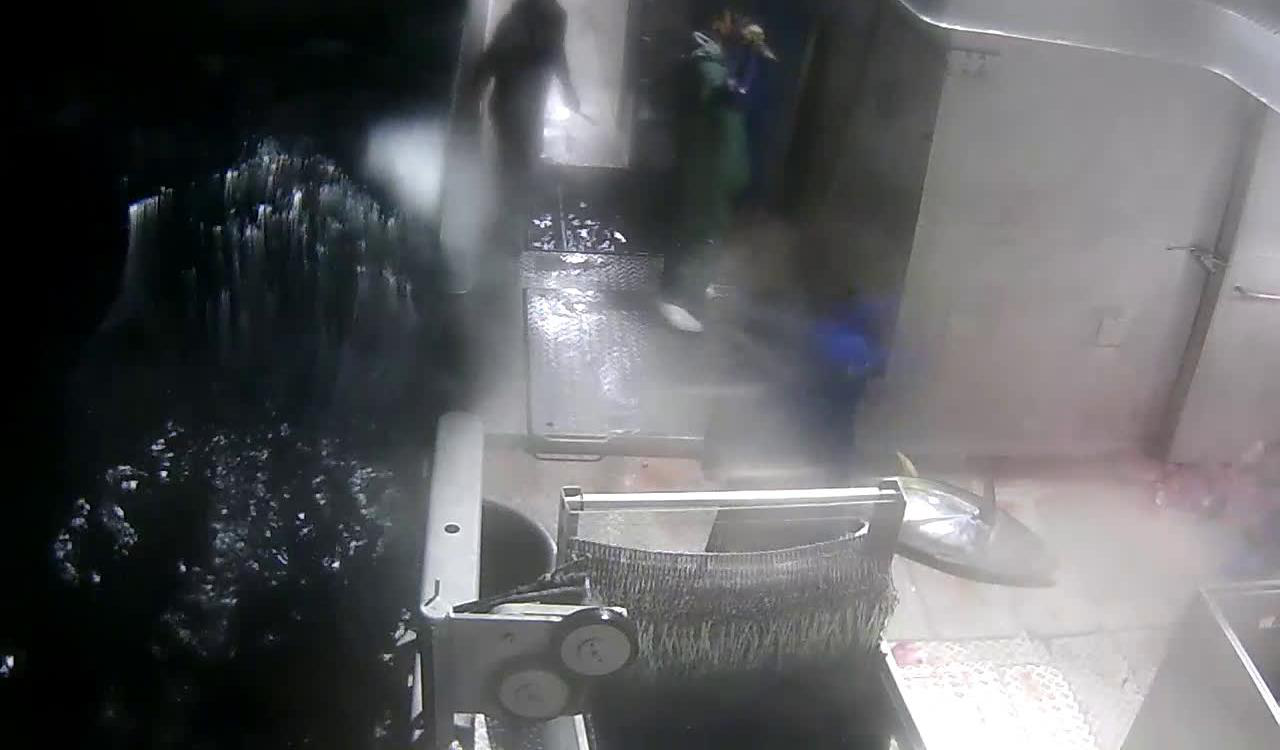

In [5]:
im

In [4]:
#from ultralytics import YOLO
model = YOLO("yolo11l.pt")
classes_wo_person = list(model.names.keys())
classes_wo_person.remove(0)
results = model(im, imgsz = (1280, 750), iou = 0.05, conf = 0.005, classes = classes_wo_person)
#results


WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
0: 480x768 1 handbag, 3 suitcases, 1 bowl, 2 toilets, 1 tv, 1 mouse, 1 remote, 3 sinks, 1 book, 2 clocks, 47.5ms
Speed: 5.0ms preprocess, 47.5ms inference, 219.9ms postprocess per image at shape (1, 3, 480, 768)


In [ ]:
results[0].plot(pil = True)

Creating dataset of yolo detected objects only

In [7]:
os.mkdir("data/train/boxes")

In [4]:
def create_boxes(image, file_name, label):

    tensor_im = torchvision.transforms.functional.pil_to_tensor(image)
    results = model(image, imgsz = (1280, 750), iou = 0.05, conf = 0.005, classes = classes_wo_person, verbose = False)

    xywh_boxes = results[0].boxes.xywh#['xywh']
    idxs = (xywh_boxes[:,2] <700) & (xywh_boxes[:,2] >50) & (xywh_boxes[:,3] <700) & (xywh_boxes[:,3]>50)
    #idxs = mask
    xyxy_boxes = results[0].boxes.xyxy[idxs].int()

    for i, xyxy_box in enumerate(xyxy_boxes):
        chunk = torchvision.transforms.functional.to_pil_image(
        tensor_im[:,
                    xyxy_box[1] :xyxy_box[3],
                    xyxy_box[0] : xyxy_box[2]
                    ]
        )
        chunk.save(f"data/train/boxes/{file_name}_{i}_{label}.jpg")
    return results[0]

In [5]:
train_dirs = os.listdir("data/train")
#train_dirs.remove('NoF')
train_dirs.remove('boxes')
model = YOLO("yolo11l.pt").to(torch.device("cuda"))
classes_wo_person = list(model.names.keys())
classes_wo_person.remove(0)


for dir in train_dirs:
    print(dir)
    files = os.listdir("data/train/" + dir)
    # if dir == 'NoF':
    #     max_id = 1000
    # else:
    #     max_id = 7000
    #max_id = 7000
    for file in files:
        #print(file)
        id = file.split('.')[0].split('_')[1]
        id = int(id)

        #if id <max_id:
        image = Image.open("data/train/" + dir + "/" + file)
        file_name = file[:-4]
        boxes = create_boxes(image, file_name, dir)

ALB
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, 

Loading data (only for exploration)

In [333]:
dir = "data/train/boxes"
files = os.listdir(dir)

tensors = []
labels = []
h = []
w = []

for file in files:
    label = re.findall(r"[A-Z].+.", file)[0][:-4]
    image_tensor = torchvision.io.decode_image(dir+"/"+file)
    h.append(image_tensor.size()[1])
    w.append(image_tensor.size()[2])
    tensors.append(image_tensor)
    labels.append(label)

KeyboardInterrupt: 

Shiny pictures ^_^

In [3]:
im_sizes = np.stack((h, w))

In [4]:
s_df = pd.DataFrame(data = im_sizes.T,columns = ['h', 'w'])
heatmap_table = s_df.groupby(['h', 'w']).size().reset_index(name='count').pivot_table(index='h', columns='w', values='count').fillna(0)
heatmap_table = heatmap_table / heatmap_table.max().max() * 255
heatmap_table = heatmap_table.astype('int8')
#heatmap_table

In [5]:
img = Image.fromarray(heatmap_table.to_numpy(), mode = "L")
#img.show()
img.save("big_beautiful_table_2.jpg")
img = Image.open("big_beautiful_table_2.jpg")

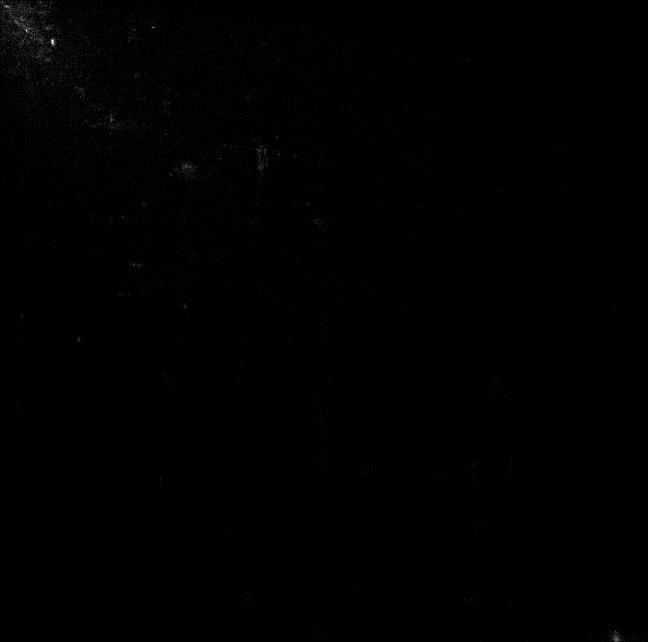

In [6]:
img ##hehe, heatmap, hehe

Model train

In [2]:
mobnetv2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None).to(torch.device("cuda"))

Using cache found in C:\Users\andry/.cache\torch\hub\pytorch_vision_v0.10.0


In [4]:
learner = BYOL(
    net = mobnetv2,
    image_size = 224,
    hidden_layer= -1,
    projection_hidden_size = 512,
    use_momentum = False
)


In [5]:
class FishDataset(torch.utils.data.Dataset):

    def __init__(self, dir):
        super().__init__()
        self.data = []
        self.labels = []

        for file in os.listdir(dir):#[:100]:
            label = re.findall(r"[A-Z].+.", file)[0][:-4]

            if label == 'NoF':
                 continue

            image_tensor = torchvision.io.decode_image(dir+"/"+file)
            resized_tensor = torchvision.transforms.Resize((224, 224))(image_tensor).to(dtype = torch.float32)
            self.data.append(resized_tensor)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]#, self.labels[index]


In [6]:
batch_size = 32
##loss
optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)
dataloader = torch.utils.data.DataLoader(FishDataset("data/train/boxes"), batch_size=batch_size, shuffle=True)

In [8]:
train_steps = len(dataloader) * 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
update_freq = 50
save_freq = 4_00
running_loss = 0.0

for train_step in range(train_steps):

    batch = next(iter(dataloader))
    loss = learner(batch.to(device = device))
    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
    if train_step % update_freq == 0:
        writer.add_scalar("loss", running_loss, train_step)
        running_loss = 0.0
    if train_step % save_freq == 0:
        checkpoint = {
            'model_state_dict': learner.state_dict(),
        }
        torch.save(checkpoint, f"models/represenation_16_2014_{train_step}.pth")

writer.close()

KeyboardInterrupt: 

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

Saving model

In [12]:
learner.eval()
output = learner.online_encoder.forward(batch[:1].to(torch.device("cuda")), return_projection  = False)

In [13]:
output = output.cpu().detach().numpy()

In [10]:
checkpoint = {
    'model_state_dict': learner.state_dict(),
}
torch.save(checkpoint, f"represenation_16_1911.pth")

Loading model back

In [94]:
rep_test = torch.load("models/represenation_16_2014_5600.pth")

In [95]:
rep_model = BYOL(
    net = mobnetv2,
    image_size = 224,
    hidden_layer= -1,
    projection_hidden_size = 512,
    use_momentum = False
)

rep_model.load_state_dict(rep_test['model_state_dict'])

<All keys matched successfully>

Creating dataset of embeddings for clustering

In [96]:
encoder = rep_model.online_encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [204]:
class EmbDataset(torch.utils.data.Dataset):
    def __init__(self, encoder, dir):
        super().__init__()
        self.data = []
        self.labels = []
        self.ids = []

        for file in os.listdir(dir):
            self.ids.append(file)
            label = re.findall(r"[A-Z].+.", file)[0][:-4]
            self.labels.append(label)
            image_tensor = torchvision.io.decode_image(dir+"/"+file)
            resized_tensor = torchvision.transforms.Resize((224, 224))(image_tensor).to(dtype = torch.float32).unsqueeze(0)
            with torch.no_grad():
                embedding = encoder.forward(resized_tensor.to(device), return_projection = False).cpu().detach().numpy().squeeze()
            self.data.append(embedding)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index], self.ids[index]


CLUSTERING

In [205]:
#embed_dataset = EmbDataset(encoder, tensors, labels, files)
embed_dataset = EmbDataset(encoder, "data/train/boxes")

General

In [206]:
clusters, labels, ids = embed_dataset.data, embed_dataset.labels, embed_dataset.ids

Class specific:

In [298]:
inspected_class = "ALB"

insp_images = []
insp_ids = []
nof_images = []
nof_ids = []
for img,label, id in embed_dataset:
    if label == inspected_class:
        # if len(insp_images)>5000:
        #     continue
        insp_images.append(img)
        insp_ids.append(id)
    if label == "NoF":
        nof_images.append(img)
        nof_ids.append(id)

In [299]:
clusters = np.concatenate((insp_images, nof_images))
labels = [inspected_class for _ in range(len(insp_images))] + ["NoF" for _ in range(len(nof_images))]

optics

In [207]:
optic = OPTICS(min_samples=5, metric = 'cosine', n_jobs = -1, cluster_method='xi')
new_new_labels = optic.fit_predict(clusters)

knn

In [37]:
import joblib

In [208]:
model = KNN(n_neighbors=5,metric = 'cosine', n_jobs = -1)
model.fit(clusters, new_new_labels)
pred = model.predict(clusters)
#pred = pred[:, 0]

In [209]:
joblib.dump(model, 'models/huge_knn_17_15_13.joblib')

['models/huge_knn_17_15_13.joblib']

In [210]:
inspection_df = pd.DataFrame(data = pred, columns = ['score'])
inspection_df['label'] = labels
inspection_df['id'] = ids

In [211]:
inspection_df['image_id'] = inspection_df['id'].apply(lambda x: x.split("_")[1])
classes = inspection_df.groupby('image_id')['score'].unique()
labels_df = inspection_df.groupby('image_id')['label'].unique()#.first() unique insted of first, because multilabelenocder

In [212]:
classes = pd.merge(classes, labels_df, how = 'left', on = 'image_id')

In [213]:
feature_mlb = MultiLabelBinarizer(sparse_output = True)
target_mlb = MultiLabelBinarizer(sparse_output = False)

X = feature_mlb.fit_transform(np.array(classes['score']))


In [214]:
y_for_log_proba =  target_mlb.fit_transform(np.array(classes['label']))
target_mlb.classes_

array(['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'], dtype=object)

In [215]:
y = classes['label'].str[0]

In [247]:
X_train, X_test, y_train, y_test, _, y_ohe = train_test_split(X, np.array(y), y_for_log_proba, test_size = 0.2, random_state = 42)

In [217]:
lg_model = LogisticRegression(n_jobs = -1, max_iter= 1_000)
lg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [218]:
x_test_m = lg_model.predict_log_proba(X_test)
np.sum(x_test_m * y_ohe)/len(y_ohe)

(371, 8)

In [252]:
lg_model = LogisticRegression(n_jobs = -1, max_iter= 1_000)
lg_model.fit(X, np.array(y))

LogisticRegression(max_iter=1000, n_jobs=-1)

UMAP

In [254]:
reducer = umap.UMAP(n_neighbors=5, min_dist = 0.1, metric='cosine')#, random_state = 13) ##params

trans = reducer.fit_transform(clusters)
# insp_trans = reducer.fit_transform(insp_images)
# nof_trans = reducer.transform(nof_images)

<Axes: >

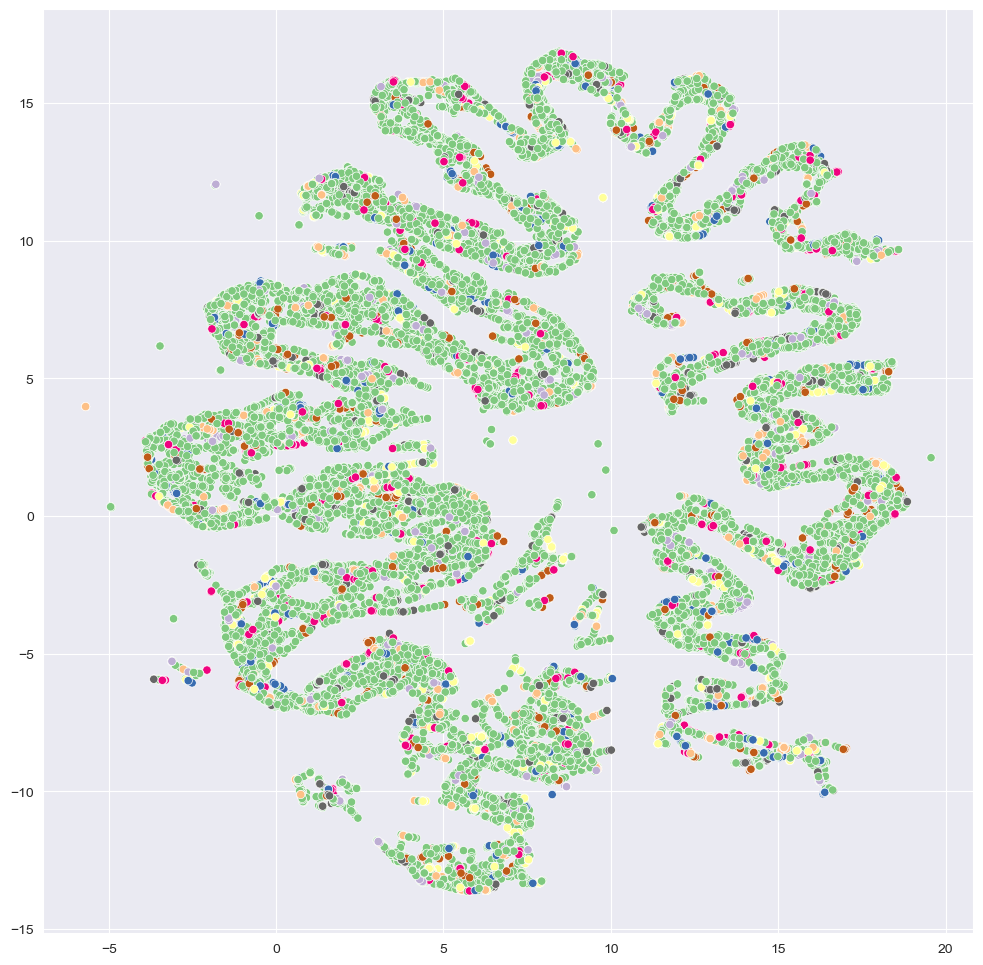

In [256]:
plt.figure(figsize=(12, 12))
sns.scatterplot(x = trans[:,0], y = trans[:,1], hue = new_new_labels, palette='Accent', legend = False)#hue_order=['BET', 'DOL', 'LAG', 'YFT','SHARK','OTHER', 'NoF'],

e2e pipe

In [238]:
model = YOLO("yolo11l.pt")
classes_wo_person = list(model.names.keys())
classes_wo_person.remove(0)

mobnetv2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None).to(torch.device("cuda"))
encoder_recipe = torch.load("models/represenation_16_2014_5600.pth")
rep_model = BYOL(
    net=mobnetv2,
    image_size=224,
    hidden_layer=-1,
    projection_hidden_size=512,
    use_momentum=False
)

rep_model.load_state_dict(rep_test['model_state_dict'])

encoder = rep_model.online_encoder
encoder.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

knn_model = joblib.load("models/huge_knn_17_15_13.joblib")

def yolo_boxes(image):

    tensor_im = torchvision.transforms.functional.pil_to_tensor(image)
    results = model(image, imgsz = (1280, 750), iou = 0.05, conf = 0.005, classes = classes_wo_person, verbose = False)

    xywh_boxes = results[0].boxes.xywh#['xywh']
    idxs = (xywh_boxes[:,2] <700) & (xywh_boxes[:,2] >50) & (xywh_boxes[:,3] <700) & (xywh_boxes[:,3]>50)
    #idxs = mask
    xyxy_boxes = results[0].boxes.xyxy[idxs].int()

    tensors = []
    for xyxy_box in xyxy_boxes:
        tensors.append(tensor_im[:,
                    xyxy_box[1] :xyxy_box[3],
                    xyxy_box[0] : xyxy_box[2]
                    ])

    return tensors

Using cache found in C:\Users\andry/.cache\torch\hub\pytorch_vision_v0.10.0


In [239]:
def get_pred(img, encoder, knn, mlb, classification_model):
    boxes = yolo_boxes(img)

    embeds = []
    for box in boxes:
        box = torchvision.transforms.Resize((224, 224))(box).to(dtype = torch.float32).unsqueeze(0)

        with torch.no_grad():
            embedding = encoder.forward(box.to(device), return_projection = False).cpu().detach().numpy().squeeze()
        embeds.append(embedding)

    if len(embeds) == 0:
        return [np.array([0,0, 0, 0, 1, 0, 0, 0])]
    if len(embeds) == 1:
        embeds = np.array(embeds).reshape(1, -1)
    objects = knn.predict(np.array(embeds))

    objects = np.expand_dims(set(objects), axis = 0)
    x = mlb.transform(objects)
    y = classification_model.predict_proba(x)
    return y

In [253]:
#files = os.listdir("data/test_stg1") + os.listdir("data/test_stg2")
#files = pd.Series(files).sort_values()
columns = lg_model.classes_.tolist()
columns.insert(0, "image")
submission_df = pd.DataFrame(columns = columns)
csv_file_name = "vf_submission.csv"
submission_df.to_csv(csv_file_name, index = False)
for file in os.listdir("data/test_stg1"):
    img = Image.open(f"data/test_stg1/{file}")

    probs = get_pred(img, encoder, knn_model, feature_mlb, lg_model)
    submission_row = probs[0].tolist()
    submission_row.insert(0,file)
    submission_row = pd.DataFrame(data = [submission_row], columns = [submission_df.columns])
    submission_row.to_csv(csv_file_name, index = False, header = False, mode = "a")

for file in os.listdir("data/test_stg2"):
    img = Image.open(f"data/test_stg2/{file}")

    probs = get_pred(img, encoder, knn_model, feature_mlb, lg_model)
    submission_row = probs[0].tolist()
    submission_row.insert(0,f"test_stg2/{file}")
    submission_row = pd.DataFrame(data = [submission_row], columns = [submission_df.columns])
    submission_row.to_csv(csv_file_name, index = False, header = False, mode = "a")



WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, updating to [1280, 768]
WARNING imgsz=[1280, 750] must be multiple of max stride 32, upda

In [199]:
import gc
gc.collect()
torch.cuda.empty_cache()